In [3]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import streamlit as st
from scipy import stats

from thesis.tools.st_utils import file_select
from thesis.tools.cli.utilities import load_gaze_data

In [4]:
from tqdm import tqdm
from numba import njit, prange, jit

from thesis.optim.metrics import *
from thesis.optim import filters

In [5]:
gaze_thresholds = ''

In [37]:
file_path = '../../../results/recognition/rc1_gaze_at_5x.json'
with open(file_path) as file:
    data = json.load(file)

In [129]:
base_path = '../../../results/recognition/'
file_names = ('rc1_gaze_at_1x.json', 'rc1_gaze_at_2x.json', 'rc1_gaze_at_5x.json')
files = []
for fpath in file_names: 
    with open(os.path.join(base_path, fpath)) as file:
        files.append(json.load(file))

In [131]:
scales = ('1x', '2x', '5x')
files = {s: f for s, f in zip(scales, files)}

In [3]:
config = data['config']

NameError: name 'data' is not defined

In [5]:
#gaze_sets = ('far_home', 'mor_home', 'anton', 'maja', 'jakob')
gaze_sets = ('anton', 'maja')
base_path = '/Users/Anton/MEGA/Data/thesis/gaze'
gaze_paths = [os.path.join(base_path, g) for g in gaze_sets]
datasets = load_gaze_data(gaze_paths)

60.0
60.0


In [6]:
def test_filter(f_func, args):
    logger = Logger()
    me = GazeAccuracy()

    for dset in datasets:
        for sample in tqdm(dset.test_samples):
            filtered = f_func(sample.image, **args)
            me.log(logger, dset.model, sample, filtered)
    
    return logger

In [47]:
res = []
for k, v in config['filters'].items():
    res.append(test_filter(getattr(filters, k), v))

100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [130]:
@njit
def metrics(intra, inter, t):
    tp = (intra <= t).sum()
    tn = (inter > t).sum()
    fp = (inter <= t).sum()
    fn = (intra > t).sum()
    return {
        'threshold': t,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'far': fp/(fp+tn),
        'frr': fn/(fn+tp)
    }

@njit
def find_gt(sorted_array, value, start=0):
    i = start
    while i < len(sorted_array):
        if sorted_array[i] >= value:
            break
        i += 1
    return i

def line(intra, inter):
    res = []
    
    sorted_intra = np.sort(intra)
    sorted_inter = np.sort(inter)
    n_intra = len(intra)
    n_inter = len(inter)
    intra_idx = 0
    inter_idx = 0
    for i in prange(2000):
        x = i/2000
        
        intra_idx = find_gt(sorted_intra, x, intra_idx)
        inter_idx = find_gt(sorted_inter, x, inter_idx)
        
        tp = intra_idx
        tn = n_inter - inter_idx
        fp = inter_idx
        fn = n_intra - intra_idx
        
        m = {
            'threshold': x,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'far': fp/(fp+tn),
            'frr': fn/(fn+tp),
        }
        res.append(m)
    return res

In [38]:
res = []
for spec in tqdm(data['results'].keys()):
    intra = np.array(data['results'][spec]['intra_distance'])
    inter = np.array(data['results'][spec]['inter_distance'])
    ls = line(intra, inter)
    ls = list(map(dict, ls))
    for l in ls:
        l['name'] = spec
        l['scale'] = 
    res.extend(ls)

100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


In [90]:
df = pd.DataFrame.from_records(res)
df['precision'] = df['tp']/(df['tp']+df['fp'])
df['recall'] = df['tp']/(df['tp']+df['fn'])
df['f1'] = (df['precision']*df['recall'])/(df['precision'] + df['recall'])
df['accuracy'] = (df['tp']+df['tn'])/(df['tp']+df['tn']+df['fp']+df['fn'])

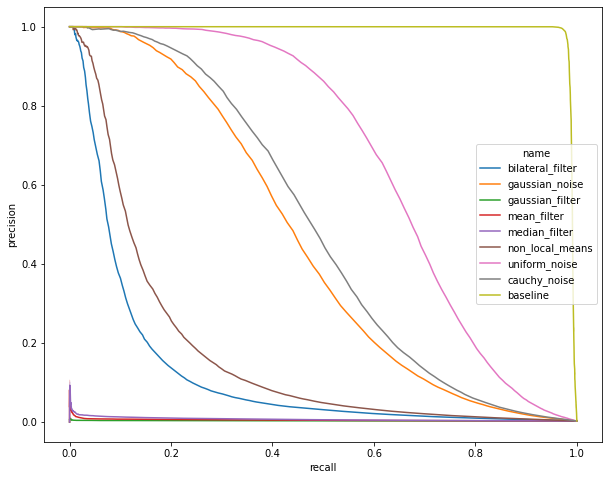

In [96]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x='recall', y='precision', hue='name', data=df, ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')

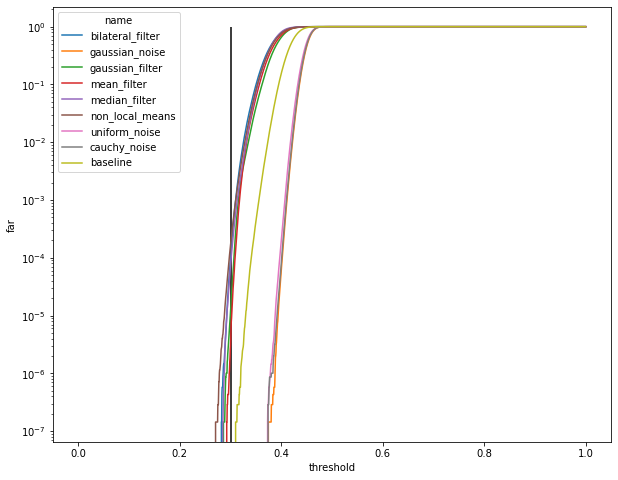

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x='threshold', y='far', hue='name', data=df, ax=ax)
ax.set_yscale('log')
ax.vlines(0.3, 0, 1)

In [91]:
pv = df.pivot(columns='name', index='threshold')

In [115]:
ts = np.round(np.arange(0.3, 0.4, 0.01), decimals=2)
pv.loc[ts]['far']

name,baseline,bilateral_filter,cauchy_noise,gaussian_filter,gaussian_noise,mean_filter,median_filter,non_local_means,uniform_noise
threshold,,,,,,,,,
0.30,0.000000e+00,0.000104,0.000000e+00,0.000013,0.000000e+00,0.000003,0.000076,0.000167,0.000000
0.31,1.440130e-07,0.001010,0.000000e+00,0.000273,0.000000e+00,0.000136,0.000590,0.000964,0.000000
0.32,8.640779e-07,0.004977,0.000000e+00,0.002064,0.000000e+00,0.001621,0.002644,0.003859,0.000000
0.33,1.108900e-05,0.016831,0.000000e+00,0.006100,0.000000e+00,0.008185,0.009191,0.012560,0.000000
0.34,8.424760e-05,0.043774,0.000000e+00,0.016399,0.000000e+00,0.024863,0.028080,0.034249,0.000000
0.35,4.281506e-04,0.097756,0.000000e+00,0.040132,0.000000e+00,0.059326,0.072038,0.080628,0.000000
0.36,1.777984e-03,0.190801,0.000000e+00,0.086215,0.000000e+00,0.126654,0.155301,0.163593,0.000000
0.37,6.711581e-03,0.323222,0.000000e+00,0.172391,0.000000e+00,0.237574,0.288211,0.289083,0.000000
0.38,2.220176e-02,0.481142,8.640779e-07,0.307945,1.440130e-07,0.386646,0.462246,0.447391,0.000001


In [126]:
sns.set_theme('paper')
sns.set_style('whitegrid')

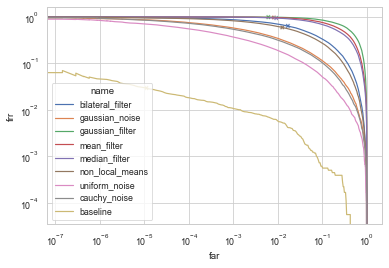

In [132]:
fig, ax = plt.subplots()

sns.lineplot(x='far', y='frr', hue='name', data=df, ax=ax, estimator=None)
sns.scatterplot(x='far', y='frr', hue='name', data=df[df['threshold'] == 0.33], ax=ax, marker='X', legend=False)

ax.set_xscale('log')
ax.set_yscale('log')

fig.savefig('out/filters.pdf')